2025-09-13 12:23:29.727485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757766209.953510      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757766210.017635      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of images per class:
Chickenpox: 1000 images
Cowpox: 1000 images
HFMD: 1000 images
Healthy: 1000 images
Measles: 1000 images
Monkeypox: 1000 images


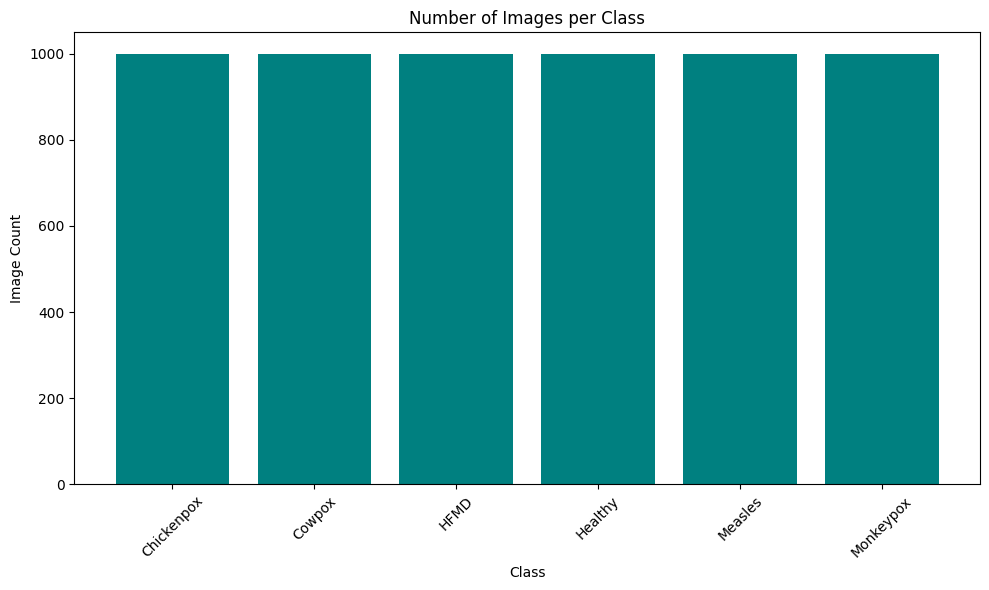

I0000 00:00:1757766225.059017      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


I0000 00:00:1757766232.962815      94 service.cc:148] XLA service 0x7b5cf80263a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757766232.963796      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757766233.551645      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/135 ━━━━━━━━━━━━━━━━━━━━ 18:19 8s/step - accuracy: 0.2500 - loss: 2.8314

I0000 00:00:1757766236.770359      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step - accuracy: 0.5691 - loss: 1.2478 - val_accuracy: 0.9117 - val_loss: 0.2995
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8919 - loss: 0.3330 - val_accuracy: 0.9647 - val_loss: 0.1447
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9511 - loss: 0.1761 - val_accuracy: 0.9796 - val_loss: 0.0938
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9637 - loss: 0.1260 - val_accuracy: 0.9809 - val_loss: 0.0700
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9669 - loss: 0.1034 - val_accuracy: 0.9851 - val_loss: 0.0507
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9818 - loss: 0.0696 - val_accuracy: 0.9836 - val_loss: 0.0540
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9868 - loss: 0.0562 - val_accuracy: 0.9891 - val_loss: 0.0366
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9894 - loss: 0.0419 - val_accuracy: 0

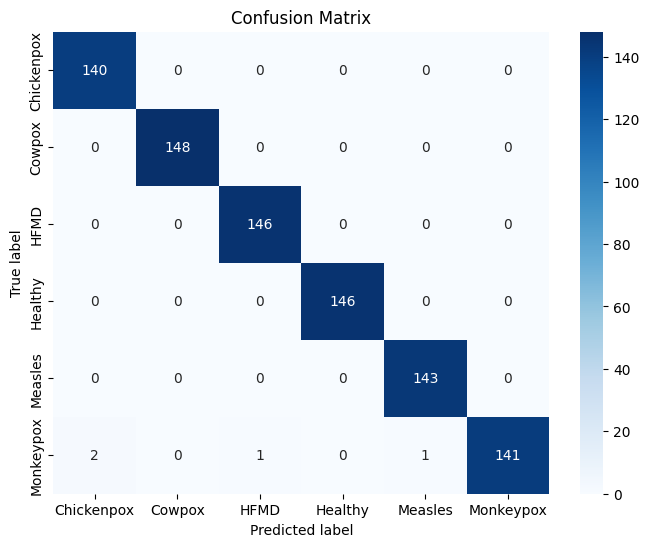

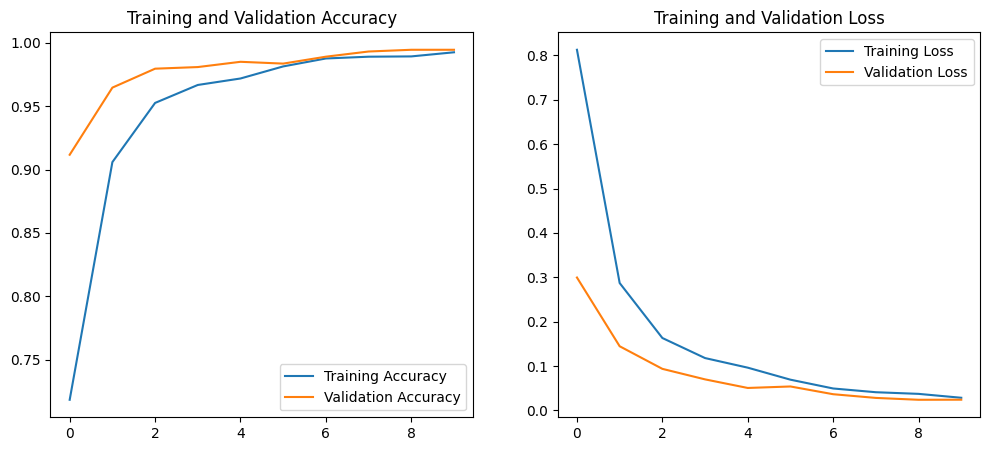

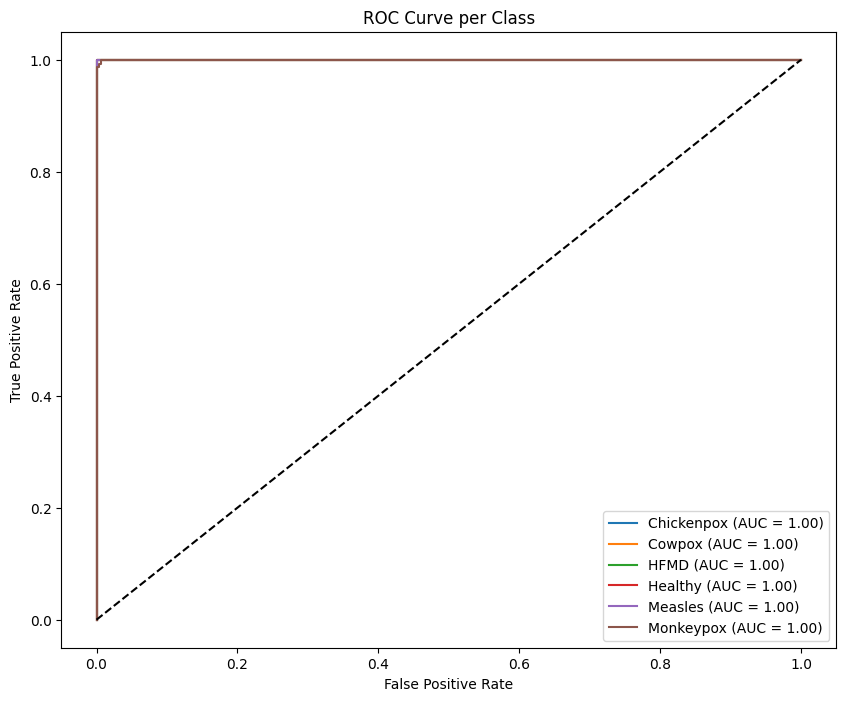

AttributeError: 'Dense' object has no attribute 'output_shape'

In [1]:
# =====================================================
# Imports
# =====================================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
import os, glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import to_categorical

# =====================================================
# Dataset Path
# =====================================================
DATASET_PATH = '/kaggle/input/monkeypox/Augmentation dataset'

classes = sorted(os.listdir(DATASET_PATH))
image_paths, image_labels = [], []

for idx, class_name in enumerate(classes):
    class_folder = os.path.join(DATASET_PATH, class_name)
    files = glob.glob(os.path.join(class_folder, '*'))
    image_paths.extend(files)
    image_labels.extend([idx] * len(files))

image_paths, image_labels = np.array(image_paths), np.array(image_labels)

label_counts = Counter(image_labels)
print("Number of images per class:")
for idx in sorted(label_counts):
    print(f"{classes[idx]}: {label_counts[idx]} images")

plt.figure(figsize=(10, 6))
plt.bar([classes[i] for i in label_counts.keys()], label_counts.values(), color='teal')
plt.title("Number of Images per Class")
plt.xlabel("Class"); plt.ylabel("Image Count"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# =====================================================
# Split dataset
# =====================================================
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, stratify=train_labels, random_state=42)

IMG_SIZE, BATCH_SIZE = (224, 224), 32

# =====================================================
# Data Generator
# =====================================================
def path_label_generator(paths, labels, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1 if augment else 0,
        zoom_range=0.2 if augment else 0,
        horizontal_flip=augment)

    while True:
        if shuffle: indices = np.random.permutation(len(paths))
        else: indices = np.arange(len(paths))
        for start in range(0, len(paths), batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            batch_images, batch_labels = [], []
            for i in batch_idx:
                img = tf.keras.preprocessing.image.load_img(paths[i], target_size=IMG_SIZE)
                img = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img); batch_labels.append(labels[i])
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=len(classes))
            batch_images = datagen.standardize(batch_images)
            yield batch_images, batch_labels

train_generator = path_label_generator(train_paths, train_labels, augment=True)
val_generator = path_label_generator(val_paths, val_labels, shuffle=False, augment=False)
test_generator = path_label_generator(test_paths, test_labels, shuffle=False, augment=False)

train_steps, val_steps, test_steps = len(train_paths)//BATCH_SIZE, len(val_paths)//BATCH_SIZE, len(test_paths)//BATCH_SIZE

# =====================================================
# Model
# =====================================================
conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
for layer in conv_base.layers: layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(train_generator, steps_per_epoch=train_steps,
                    validation_data=val_generator, validation_steps=val_steps,
                    epochs=EPOCHS)

# =====================================================
# Evaluation
# =====================================================
loss, accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss:.4f}"); print(f"Test Accuracy: {accuracy:.4f}")

predictions, true_labels = [], []
for _ in range(test_steps):
    x_batch, y_batch = next(test_generator)
    preds = model.predict(x_batch)
    predictions.append(preds); true_labels.append(y_batch)

predictions, true_labels = np.vstack(predictions), np.vstack(true_labels)
predicted_classes, true_classes = np.argmax(predictions, axis=1), np.argmax(true_labels, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=classes)
print(report)

cm = confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix'); plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.show()

acc, val_acc, loss_hist, val_loss = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right'); plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_hist, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right'); plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve per Class'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right'); plt.show()

# =====================================================
# Install Explainability libs
# =====================================================
!pip install shap lime opencv-python scikit-image --quiet

import shap, cv2, warnings
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as kimage
warnings.filterwarnings("ignore")

# =====================================================
# Explainability helpers
# =====================================================
def load_and_preprocess(path):
    img = kimage.load_img(path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr.copy())

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap); heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return img, cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4: return layer.name
    raise ValueError("No conv layer found!")

def lime_classifier_fn(images):
    arr = np.stack([preprocess_input(img.astype(np.float32)) for img in images], axis=0)
    return model.predict(arr)

def run_lime(img_path):
    explainer = lime_image.LimeImageExplainer()
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, IMG_SIZE)
    explanation = explainer.explain_instance(orig, classifier_fn=lime_classifier_fn,
                                             top_labels=1, hide_color=0, num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                                num_features=5, hide_rest=False)
    return mark_boundaries(temp / 255.0, mask)

def run_shap(sample_paths, num_bg=5):
    bg_paths = np.random.choice(train_paths, num_bg, replace=False)
    bg_imgs = np.vstack([load_and_preprocess(p) for p in bg_paths])
    test_imgs = np.vstack([load_and_preprocess(p) for p in sample_paths])
    explainer = shap.GradientExplainer((model.inputs, model.output), bg_imgs)
    shap_values = explainer.shap_values(test_imgs, nsamples=20)
    for i, path in enumerate(sample_paths):
        pred_class = np.argmax(model.predict(test_imgs[i:i+1]))
        shap_img = shap_values[pred_class][i].sum(-1)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(kimage.load_img(path, target_size=IMG_SIZE)); plt.title("Original")
        plt.subplot(1,2,2); plt.imshow(shap_img, cmap='jet'); plt.title(f"SHAP ({classes[pred_class]})")
        plt.show()

# =====================================================
# Run Explainability on few test images
# =====================================================
sample_paths = np.random.choice(test_paths, 3, replace=False)
last_conv = find_last_conv_layer(model)

for path in sample_paths:
    img_array = load_and_preprocess(path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv)
    orig, overlay = overlay_heatmap(path, heatmap)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM")
    plt.show()
    plt.imshow(run_lime(path)); plt.title("LIME"); plt.axis("off"); plt.show()

run_shap(sample_paths)


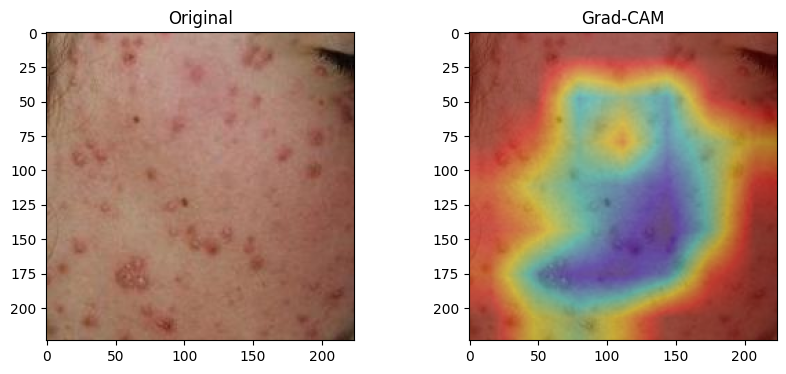

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

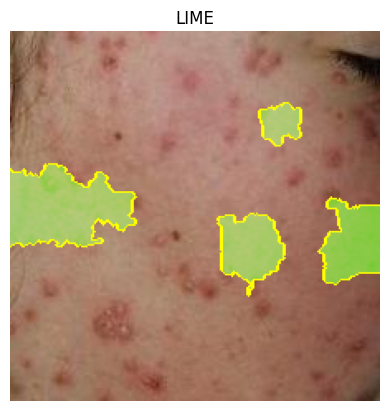

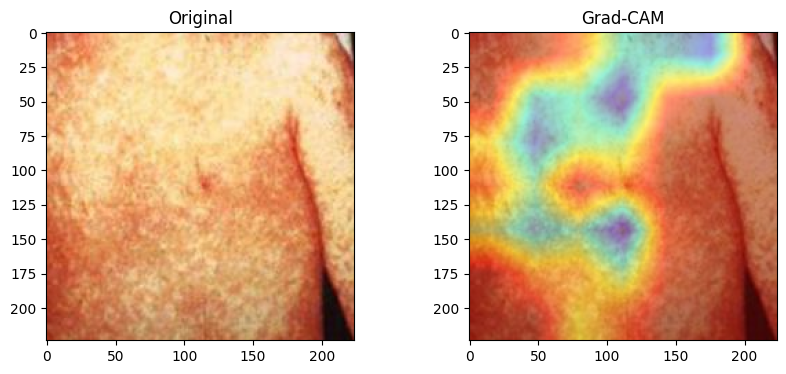

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

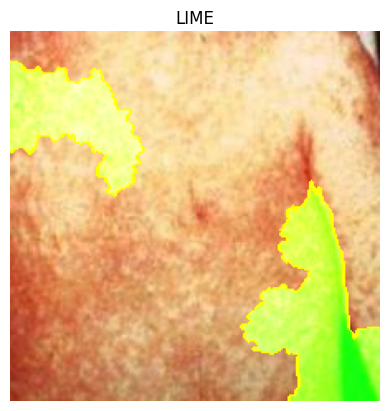

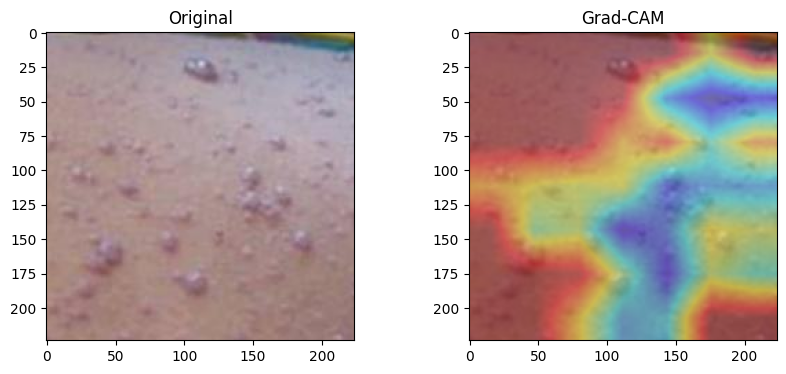

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

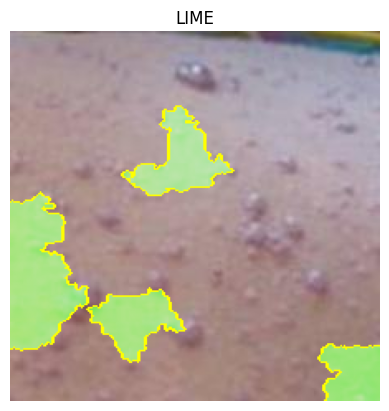

AttributeError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_gradient.py", line 217, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'learning_phase'


In [11]:
# =====================================================
# Install Explainability libs
# =====================================================
!pip install shap lime opencv-python scikit-image --quiet

import shap, cv2, warnings
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as kimage
warnings.filterwarnings("ignore")

# =====================================================
# Explainability helpers
# =====================================================
def load_and_preprocess(path):
    img = kimage.load_img(path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr.copy())

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return img, cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

def find_last_conv_layer(model):
    """Find the last Conv2D layer for Grad-CAM"""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model")

def lime_classifier_fn(images):
    arr = np.stack([preprocess_input(img.astype(np.float32)) for img in images], axis=0)
    return model.predict(arr)

def run_lime(img_path):
    explainer = lime_image.LimeImageExplainer()
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, IMG_SIZE)
    explanation = explainer.explain_instance(
        orig,
        classifier_fn=lime_classifier_fn,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=5,
        hide_rest=False
    )
    return mark_boundaries(temp / 255.0, mask)

def run_shap(sample_paths, num_bg=5):
    # pick a few background images
    bg_paths = np.random.choice(train_paths, num_bg, replace=False)
    bg_imgs = np.vstack([load_and_preprocess(p) for p in bg_paths])
    test_imgs = np.vstack([load_and_preprocess(p) for p in sample_paths])
    
    # ✅ Use GradientExplainer with model directly (fixes tuple error)
    explainer = shap.GradientExplainer(model, bg_imgs)
    shap_values = explainer.shap_values(test_imgs, nsamples=20)
    
    # visualize for each test image
    for i, path in enumerate(sample_paths):
        pred_class = np.argmax(model.predict(test_imgs[i:i+1]))
        shap_img = shap_values[pred_class][i].sum(-1)  # collapse channels
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(kimage.load_img(path, target_size=IMG_SIZE)); plt.title("Original")
        plt.subplot(1,2,2)
        plt.imshow(shap_img, cmap='jet'); plt.title(f"SHAP ({classes[pred_class]})")
        plt.show()

# =====================================================
# Run Explainability on few test images
# =====================================================
sample_paths = np.random.choice(test_paths, 3, replace=False)
last_conv = find_last_conv_layer(model)

for path in sample_paths:
    img_array = load_and_preprocess(path)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv)
    orig, overlay = overlay_heatmap(path, heatmap)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM")
    plt.show()

    # LIME
    plt.imshow(run_lime(path)); plt.title("LIME"); plt.axis("off"); plt.show()

# Run SHAP
run_shap(sample_paths)


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.5928 - loss: 1.1346 - val_accuracy: 0.9253 - val_loss: 0.2745
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8871 - loss: 0.3328 - val_accuracy: 0.9552 - val_loss: 0.1534
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9454 - loss: 0.1880 - val_accuracy: 0.9796 - val_loss: 0.0836
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9704 - loss: 0.1072 - val_accuracy: 0.9768 - val_loss: 0.0754
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9734 - loss: 0.0874 - val_accuracy: 0.9891 - val_loss: 0.0432
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9812 - loss: 0.0701 - val_accuracy: 0.9918 - val_loss: 0.0290
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9887 - loss: 0.0453 - val_accuracy: 0.9918 - val_loss: 0.0291
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9913 - loss: 0.0360 - val_

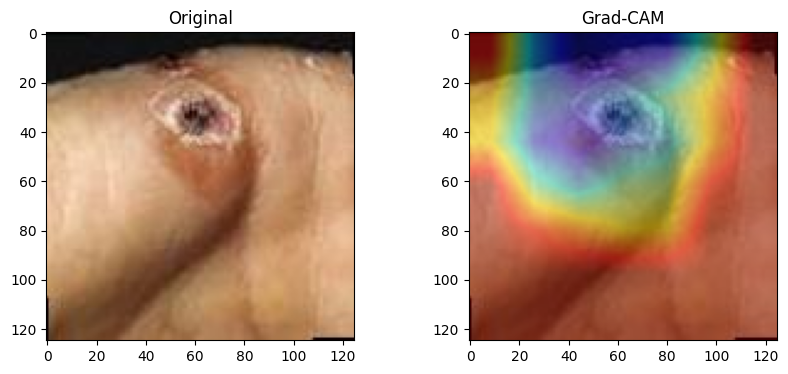

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

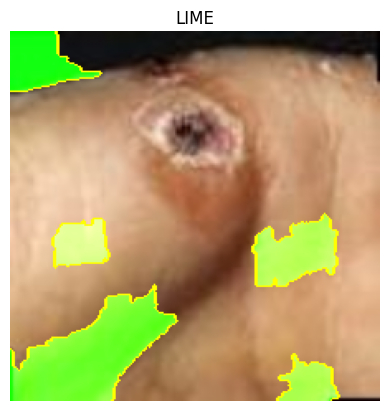

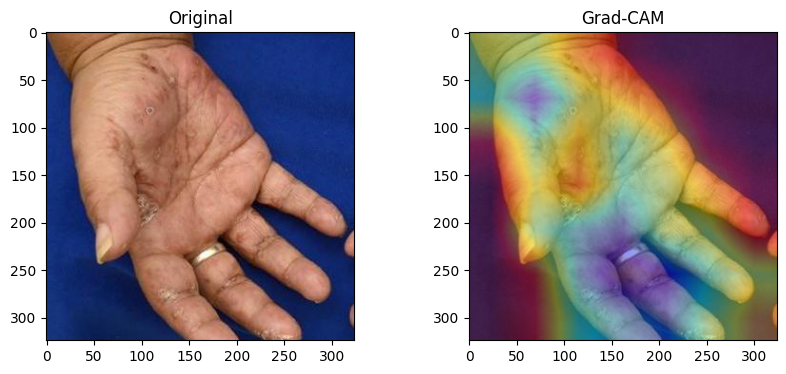

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

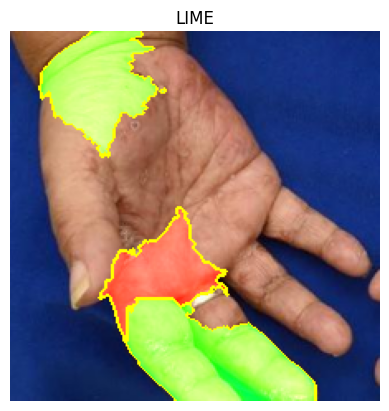

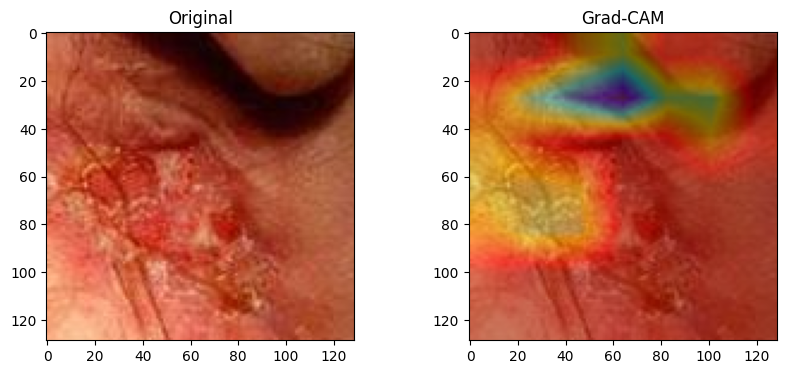

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

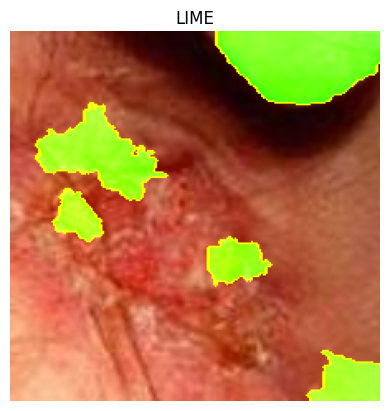

ValueError: Passed in object [[[[-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]
   ...
   [-0.84313726 -0.88235295 -0.90588236]
   [-0.9529412  -0.99215686 -1.        ]
   [-0.9529412  -0.99215686 -1.        ]]

  [[-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]
   [-1.         -0.99215686 -1.        ]
   ...
   [-0.84313726 -0.88235295 -0.90588236]
   [-0.9529412  -0.99215686 -1.        ]
   [-0.9529412  -0.99215686 -1.        ]]

  [[-0.9137255  -0.88235295 -0.8901961 ]
   [-0.9137255  -0.88235295 -0.8901961 ]
   [-0.9137255  -0.88235295 -0.8901961 ]
   ...
   [-0.827451   -0.8666667  -0.8901961 ]
   [-0.9529412  -0.99215686 -1.        ]
   [-0.9529412  -0.99215686 -1.        ]]

  ...

  [[-0.85882354 -1.         -1.        ]
   [-0.85882354 -1.         -1.        ]
   [-0.30196077 -0.4980392  -0.654902  ]
   ...
   [ 0.45882356  0.20784318  0.01176476]
   [ 0.4666667   0.21568632  0.0196079 ]
   [ 0.4666667   0.21568632  0.0196079 ]]

  [[-0.8509804  -1.         -1.        ]
   [-0.8509804  -1.         -1.        ]
   [-0.3098039  -0.5058824  -0.6627451 ]
   ...
   [-0.8666667  -1.         -1.        ]
   [-0.85882354 -1.         -1.        ]
   [-0.85882354 -1.         -1.        ]]

  [[-0.8509804  -1.         -1.        ]
   [-0.8509804  -1.         -1.        ]
   [-0.3098039  -0.5058824  -0.6627451 ]
   ...
   [-0.8666667  -1.         -1.        ]
   [-0.85882354 -1.         -1.        ]
   [-0.85882354 -1.         -1.        ]]]] of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [15]:
# =====================================================
# Imports
# =====================================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2, os, glob, warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import to_categorical
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as kimage

warnings.filterwarnings("ignore")

# =====================================================
# Dataset Path
# =====================================================
DATASET_PATH = '/kaggle/input/monkeypox/Augmentation dataset'
classes = sorted(os.listdir(DATASET_PATH))
image_paths, image_labels = [], []

for idx, class_name in enumerate(classes):
    class_folder = os.path.join(DATASET_PATH, class_name)
    files = glob.glob(os.path.join(class_folder, '*'))
    image_paths.extend(files)
    image_labels.extend([idx] * len(files))

image_paths, image_labels = np.array(image_paths), np.array(image_labels)

# =====================================================
# Split dataset
# =====================================================
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.15, stratify=image_labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, stratify=train_labels, random_state=42)

IMG_SIZE, BATCH_SIZE = (224, 224), 32

# =====================================================
# Data Generator
# =====================================================
def path_label_generator(paths, labels, batch_size=BATCH_SIZE, shuffle=True, augment=False):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1 if augment else 0,
        zoom_range=0.2 if augment else 0,
        horizontal_flip=augment)

    while True:
        if shuffle: indices = np.random.permutation(len(paths))
        else: indices = np.arange(len(paths))
        for start in range(0, len(paths), batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            batch_images, batch_labels = [], []
            for i in batch_idx:
                img = tf.keras.preprocessing.image.load_img(paths[i], target_size=IMG_SIZE)
                img = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img); batch_labels.append(labels[i])
            batch_images = np.array(batch_images)
            batch_labels = to_categorical(batch_labels, num_classes=len(classes))
            batch_images = datagen.standardize(batch_images)
            yield batch_images, batch_labels

train_generator = path_label_generator(train_paths, train_labels, augment=True)
val_generator = path_label_generator(val_paths, val_labels, shuffle=False, augment=False)
test_generator = path_label_generator(test_paths, test_labels, shuffle=False, augment=False)

train_steps, val_steps, test_steps = len(train_paths)//BATCH_SIZE, len(val_paths)//BATCH_SIZE, len(test_paths)//BATCH_SIZE

# =====================================================
# Model
# =====================================================
conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3))
for layer in conv_base.layers: layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(classes), activation='softmax')(x)
model = Model(inputs=conv_base.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10
history = model.fit(train_generator, steps_per_epoch=train_steps,
                    validation_data=val_generator, validation_steps=val_steps,
                    epochs=EPOCHS)

# =====================================================
# Evaluation
# =====================================================
loss, accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss:.4f}"); print(f"Test Accuracy: {accuracy:.4f}")

# =====================================================
# Grad-CAM, LIME, and SHAP-like Explanation
# =====================================================
def load_and_preprocess(path):
    img = kimage.load_img(path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr.copy())

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found!")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0)/(tf.reduce_max(heatmap)+1e-8)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return img, cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

def lime_classifier_fn(images):
    arr = np.stack([preprocess_input(img.astype(np.float32)) for img in images], axis=0)
    return model.predict(arr)

def run_lime(img_path):
    explainer = lime_image.LimeImageExplainer()
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, IMG_SIZE)
    explanation = explainer.explain_instance(
        orig,
        classifier_fn=lime_classifier_fn,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=5,
        hide_rest=False
    )
    return mark_boundaries(temp/255.0, mask)

def run_custom_shap(sample_paths):
    # Custom SHAP-like gradient explanation
    for path in sample_paths:
        img_array = load_and_preprocess(path)
        with tf.GradientTape() as tape:
            tape.watch(img_array)
            preds = model(img_array)
            pred_class = tf.argmax(preds[0])
            loss = preds[0, pred_class]
        grads = tape.gradient(loss, img_array)[0]
        grads = np.mean(grads, axis=-1)  # collapse channels
        img = kimage.load_img(path, target_size=IMG_SIZE)
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
        plt.subplot(1,2,2); plt.imshow(grads, cmap='jet'); plt.title(f"Custom SHAP ({classes[pred_class]})")
        plt.show()

# =====================================================
# Run Explainability on few test images
# =====================================================
sample_paths = np.random.choice(test_paths, 3, replace=False)
last_conv = find_last_conv_layer(model)

for path in sample_paths:
    img_array = load_and_preprocess(path)

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv)
    orig, overlay = overlay_heatmap(path, heatmap)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM")
    plt.show()

    # LIME
    plt.imshow(run_lime(path)); plt.title("LIME"); plt.axis("off"); plt.show()

# Custom SHAP-like
run_custom_shap(sample_paths)


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

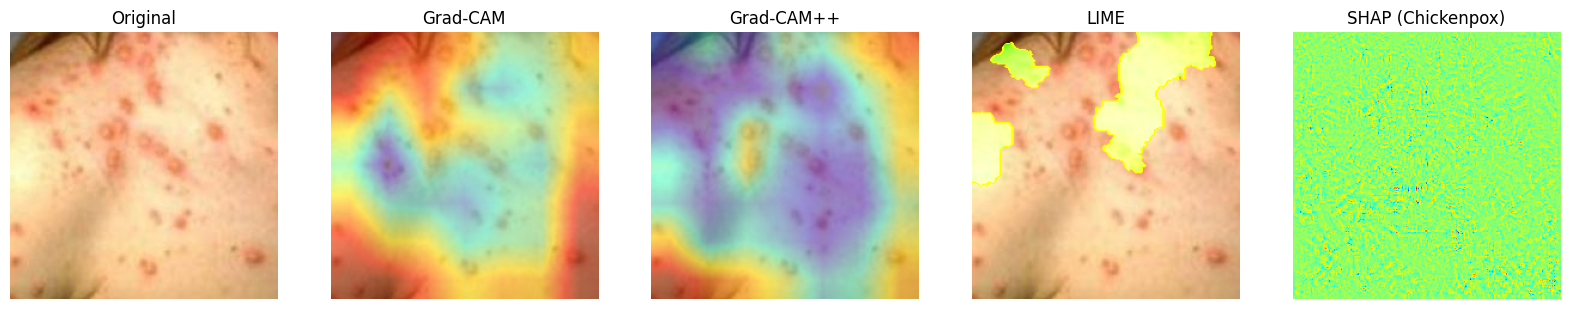

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

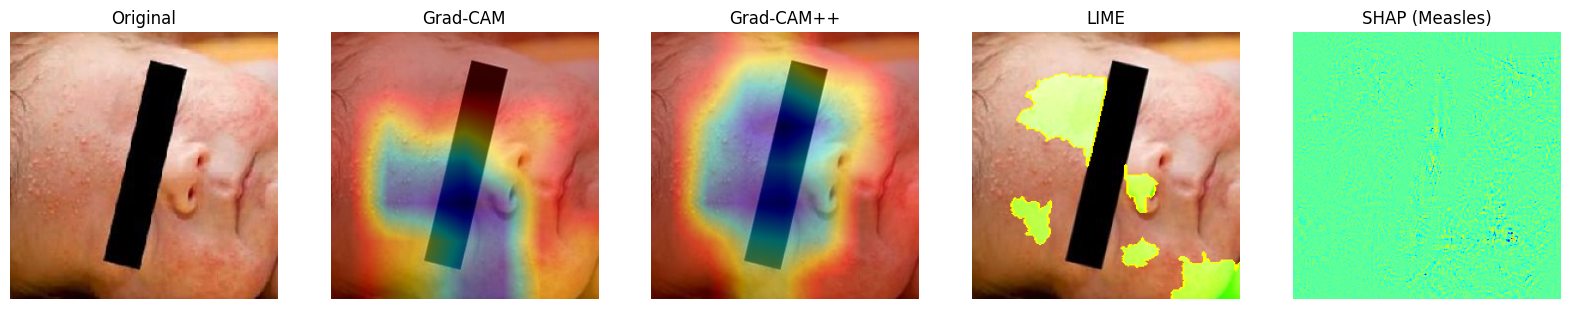

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

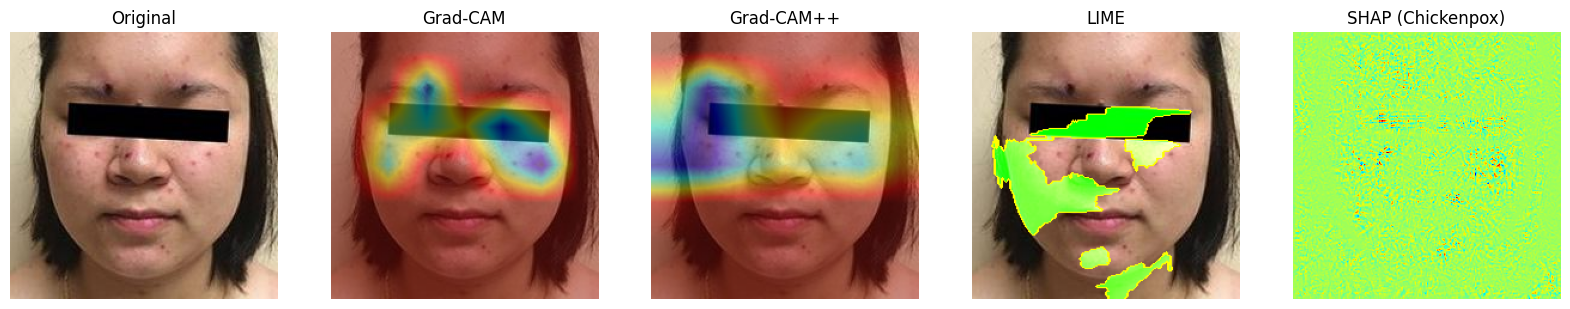

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

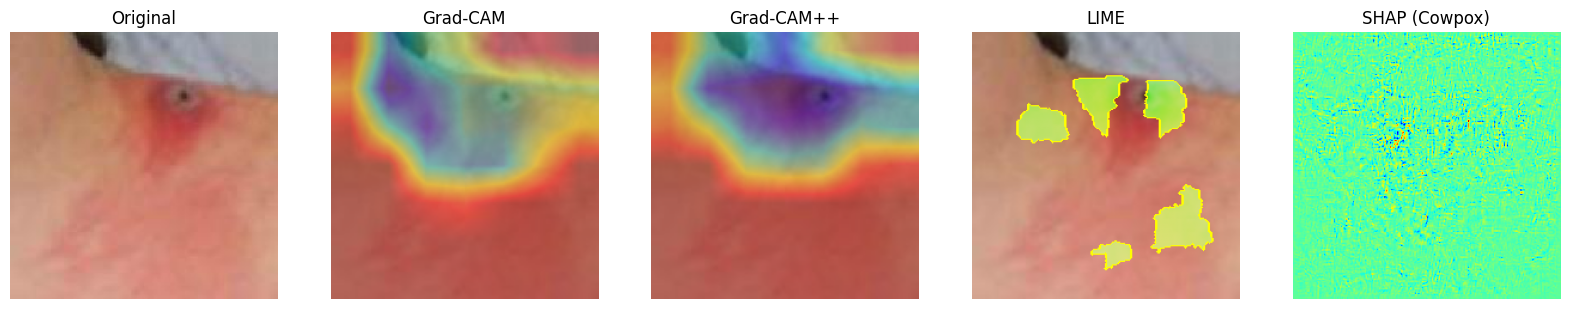

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

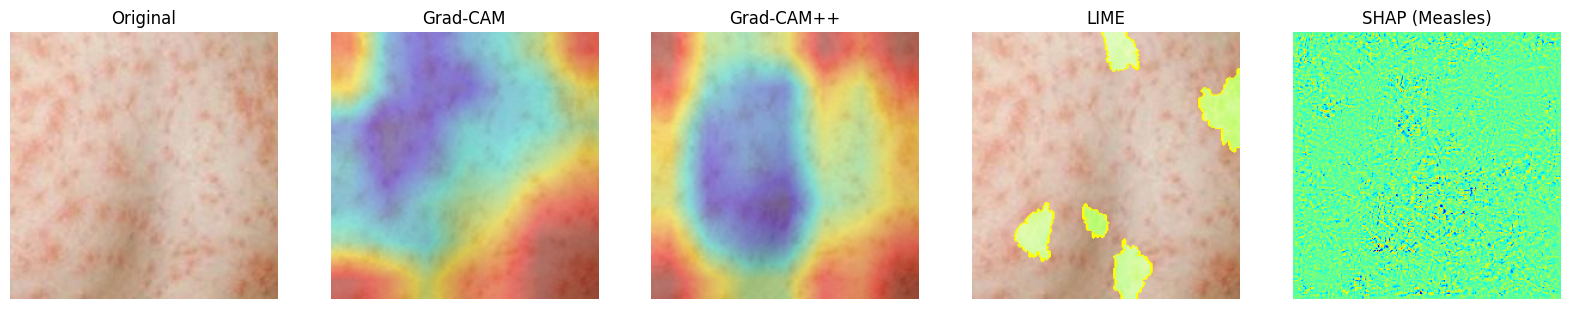

In [29]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2, warnings
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as kimage
warnings.filterwarnings("ignore")

# ===============================
# Helpers
# ===============================
def load_and_preprocess(path):
    img = kimage.load_img(path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr.copy())

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found!")

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return img, cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Grad-CAM++ (approximate)
def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    alpha = tf.nn.relu(grads)
    weights = tf.reduce_mean(alpha, axis=(0,1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# LIME
def lime_classifier_fn(images):
    arr = np.stack([preprocess_input(img.astype(np.float32)) for img in images], axis=0)
    return model.predict(arr)

def run_lime(img_path):
    explainer = lime_image.LimeImageExplainer()
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, IMG_SIZE)
    explanation = explainer.explain_instance(
        orig,
        classifier_fn=lime_classifier_fn,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=5,
        hide_rest=False
    )
    return mark_boundaries(temp/255.0, mask)

# SHAP-like gradient
def run_custom_shap(img_path):
    img_array = load_and_preprocess(img_path)
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        pred_class = tf.argmax(preds[0])
        loss = preds[0, pred_class]
    grads = tape.gradient(loss, img_tensor)[0]
    grads = np.mean(grads, axis=-1)
    return grads, pred_class

# ===============================
# Run on 5 random samples
# ===============================
sample_paths = np.random.choice(test_paths, 5, replace=False)
last_conv = find_last_conv_layer(model)

for path in sample_paths:
    orig_img = kimage.load_img(path, target_size=IMG_SIZE)
    img_array = load_and_preprocess(path)

    gradcam_heatmap = make_gradcam_heatmap(img_array, model, last_conv)
    _, gradcam_overlay = overlay_heatmap(path, gradcam_heatmap)

    gradcam_plus_heatmap = make_gradcam_plus_plus_heatmap(img_array, model, last_conv)
    _, gradcam_plus_overlay = overlay_heatmap(path, gradcam_plus_heatmap)

    lime_img = run_lime(path)
    shap_img, pred_class = run_custom_shap(path)

    plt.figure(figsize=(20,5))
    plt.subplot(1,5,1); plt.imshow(orig_img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,5,2); plt.imshow(gradcam_overlay); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,5,3); plt.imshow(gradcam_plus_overlay); plt.title("Grad-CAM++"); plt.axis("off")
    plt.subplot(1,5,4); plt.imshow(lime_img); plt.title("LIME"); plt.axis("off")
    plt.subplot(1,5,5); plt.imshow(shap_img, cmap='jet'); plt.title(f"SHAP ({classes[pred_class]})"); plt.axis("off")
    plt.show()


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

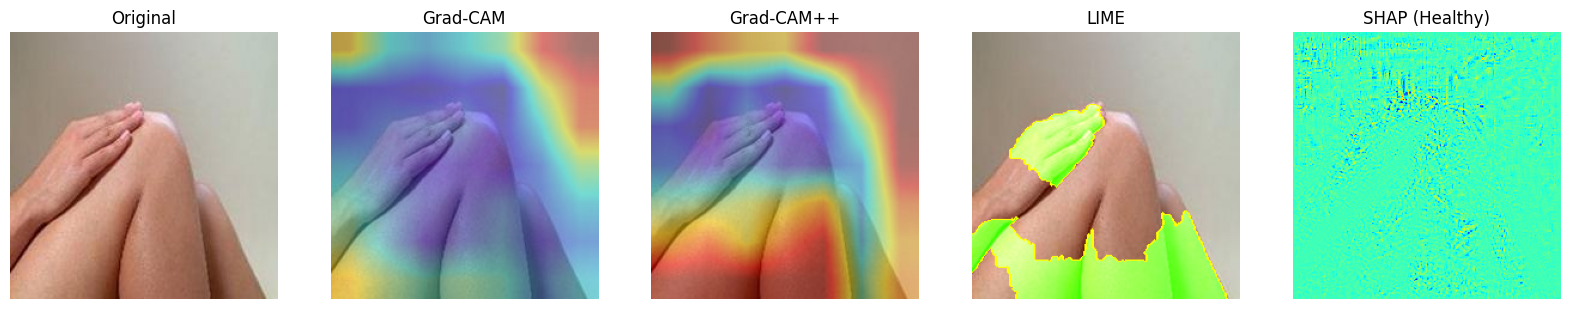

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

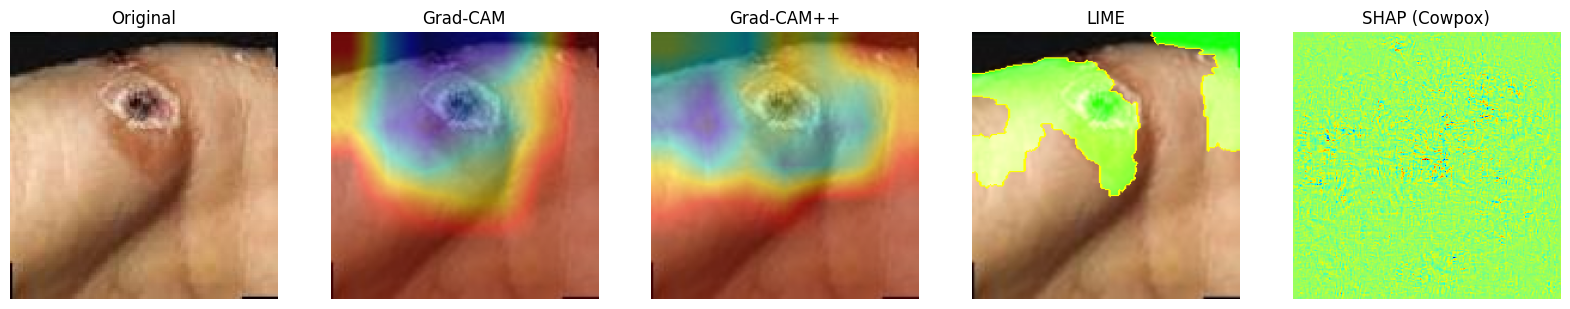

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

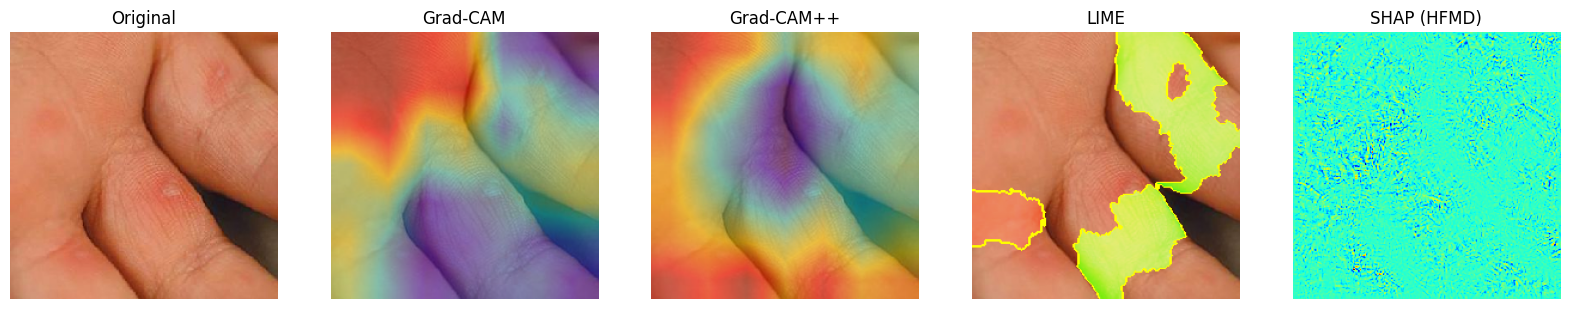

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

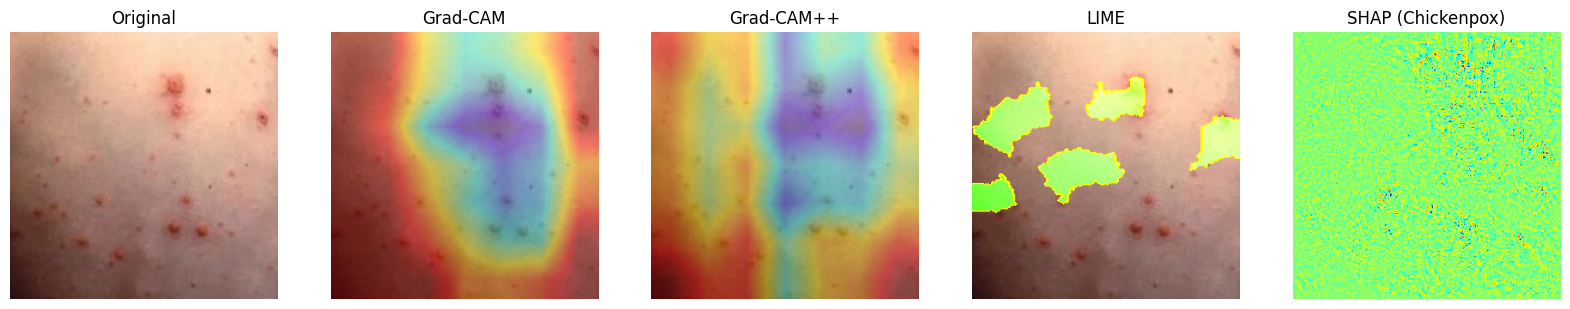

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

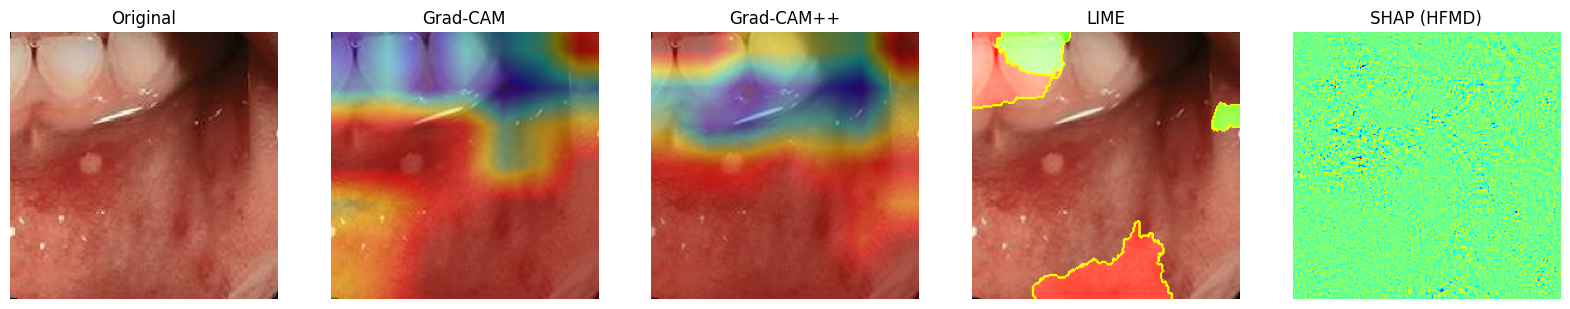

In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2, warnings
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as kimage
warnings.filterwarnings("ignore")

# ===============================
# Helpers
# ===============================
def load_and_preprocess(path):
    img = kimage.load_img(path, target_size=IMG_SIZE)
    arr = kimage.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    return preprocess_input(arr.copy())

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found!")

def overlay_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return img, cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Grad-CAM++ (approximate)
def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    alpha = tf.nn.relu(grads)
    weights = tf.reduce_mean(alpha, axis=(0,1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# LIME
def lime_classifier_fn(images):
    arr = np.stack([preprocess_input(img.astype(np.float32)) for img in images], axis=0)
    return model.predict(arr)

def run_lime(img_path):
    explainer = lime_image.LimeImageExplainer()
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    orig = cv2.resize(orig, IMG_SIZE)
    explanation = explainer.explain_instance(
        orig,
        classifier_fn=lime_classifier_fn,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=5,
        hide_rest=False
    )
    return mark_boundaries(temp/255.0, mask)

# SHAP-like gradient
def run_custom_shap(img_path):
    img_array = load_and_preprocess(img_path)
    img_tensor = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        pred_class = tf.argmax(preds[0])
        loss = preds[0, pred_class]
    grads = tape.gradient(loss, img_tensor)[0]
    grads = np.mean(grads, axis=-1)
    return grads, pred_class

# ===============================
# Run on 5 random samples
# ===============================
sample_paths = np.random.choice(test_paths, 5, replace=False)
last_conv = find_last_conv_layer(model)

for path in sample_paths:
    orig_img = kimage.load_img(path, target_size=IMG_SIZE)
    img_array = load_and_preprocess(path)

    gradcam_heatmap = make_gradcam_heatmap(img_array, model, last_conv)
    _, gradcam_overlay = overlay_heatmap(path, gradcam_heatmap)

    gradcam_plus_heatmap = make_gradcam_plus_plus_heatmap(img_array, model, last_conv)
    _, gradcam_plus_overlay = overlay_heatmap(path, gradcam_plus_heatmap)

    lime_img = run_lime(path)
    shap_img, pred_class = run_custom_shap(path)

    plt.figure(figsize=(20,5))
    plt.subplot(1,5,1); plt.imshow(orig_img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,5,2); plt.imshow(gradcam_overlay); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,5,3); plt.imshow(gradcam_plus_overlay); plt.title("Grad-CAM++"); plt.axis("off")
    plt.subplot(1,5,4); plt.imshow(lime_img); plt.title("LIME"); plt.axis("off")
    plt.subplot(1,5,5); plt.imshow(shap_img, cmap='jet'); plt.title(f"SHAP ({classes[pred_class]})"); plt.axis("off")
    plt.show()
